# Multi-Class Image Classification Deep Learning Model for Fruits-360 Images Using TensorFlow Take 4
### David Lowe
### July 6, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Fruits-360 Images dataset is a multi-class classification situation where we attempt to predict one of several (for this dataset 131) possible outcomes.

INTRODUCTION: This dataset contains 131 fruits and vegetables with 67692 training images and 22688 test images. All images have a resolution of 100 X 100 X 3 colors in the JPEG format. Each dataset includes 131 subdirectories, one for each type of fruit or vegetable.

From iteration Take1, we constructed a CNN model based on the InceptionV3 architecture to predict the fruit or vegetable name for the image.

From iteration Take2, we constructed a CNN model based on the ResNet50 architecture to predict the fruit or vegetable name for the image.

From iteration Take3, we constructed a CNN model based on the MobileNet architecture to predict the fruit or vegetable name for the image.

In this Take4 iteration, we will construct a CNN model based on the VGG16 architecture to predict the fruit or vegetable name for the image.

ANALYSIS: From iteration Take1, the InceptionV3 model's performance achieved an accuracy score of 99.46% after five epochs using the validation dataset. The same model processed the test dataset with an accuracy score of 98.03%.

From iteration Take2, the ResNet50 model's performance achieved an accuracy score of 99.91% after five epochs using the validation dataset. The same model processed the test dataset with an accuracy score of 99.48%.

From iteration Take3, the MobileNet model's performance achieved an accuracy score of 99.93% after five epochs using the validation dataset. The same model processed the test dataset with an accuracy score of 98.99%.

In this Take4 iteration, the VGG16 model's performance achieved an accuracy score of 100% after five epochs using the validation dataset. The same model processed the test dataset with an accuracy score of 98.47%.

CONCLUSION: In this iteration, the VGG16-based CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Fruits-360: A dataset of images containing fruits and vegetables.

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://github.com/Horea94/Fruit-Images-Dataset

One potential source of performance benchmarks: https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [ ]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [ ]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jun 29 15:13:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [ ]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [ ]:
# Load libraries and packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from datetime import datetime
import zipfile
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [ ]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
# VAL_SET_RATIO = 0.3
# TEST_SET_RATIO = 0.5

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 5
BATCH_SIZE = 32
RAW_IMAGE_SIZE = (100, 100)
TARGET_IMAGE_SIZE = (128, 128)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 131
# CLASS_LABELS = []
# CLASS_NAMES = []

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/Fruit-Images-Dataset-master/Training/'
# VALID_DIR = ''
TEST_DIR = 'staging/Fruit-Images-Dataset-master/Test/'
# TRAIN_DATASET = ''
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.5.0


In [ ]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
!rm -rf staging/
!mkdir staging/
!rm Fruit-Images-Dataset-master.zip
!wget https://dainesanalytics.com/datasets/kaggle-fruits-360-images/Fruit-Images-Dataset-master.zip

rm: cannot remove 'Fruit-Images-Dataset-master.zip': No such file or directory
--2021-06-29 15:13:31--  https://dainesanalytics.com/datasets/kaggle-fruits-360-images/Fruit-Images-Dataset-master.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.224.7.9, 13.224.7.94, 13.224.7.16, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.224.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 798281939 (761M) [application/zip]
Saving to: ‘Fruit-Images-Dataset-master.zip’

Fruit-Images-Datase 100%[===================>] 761.30M  53.3MB/s    in 13s     

2021-06-29 15:13:45 (56.9 MB/s) - ‘Fruit-Images-Dataset-master.zip’ saved [798281939/798281939]



In [ ]:
dataset_zip = 'Fruit-Images-Dataset-master.zip'
zip_ref = zipfile.ZipFile(dataset_zip, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [ ]:
datagen_kwargs = dict(rescale=1./255)
training_datagen = ImageDataGenerator(**datagen_kwargs)
# validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = False
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(training_generator))

# print('Loading and pre-processing the validation images...')
# validation_generator = validation_datagen.flow_from_directory(directory=VALID_DIR,
#                                                               target_size=TARGET_IMAGE_SIZE,
#                                                               shuffle=False,
#                                                               **dataflow_kwargs)
# print('Number of image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 67692 images belonging to 131 classes.
Number of image batches per epoch of modeling: 2116


In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        # plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

In [ ]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_param, pooling='avg')
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [ ]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor=0.5, min_lr=0.000001)
reset_random()
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(training_generator,
                                  epochs=MAX_EPOCHS,
                                #   validation_data=validation_generator,
                                #   callbacks=[learning_rate_reduction],
                                  verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/5
2116/2116 [==============================] - 182s 78ms/step - loss: 0.4584 - accuracy: 0.8883
Epoch 2/5
2116/2116 [==============================] - 163s 77ms/step - loss: 0.0412 - accuracy: 0.9891
Epoch 3/5
2116/2116 [==============================] - 163s 77ms/step - loss: 0.0317 - accuracy: 0.9923
Epoch 4/5
2116/2116 [==============================] - 163s 77ms/step - loss: 0.0193 - accuracy: 0.9954
Epoch 5/5
2116/2116 [==============================] - 163s 77ms/step - loss: 1.1531e-05 - accuracy: 1.0000
Total time for model fitting: 0:15:15.998515


In [ ]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 131)               67203     
Total params: 14,781,891
Trainable params: 14,781,891
Non-trainable params: 0
_________________________________________________________________


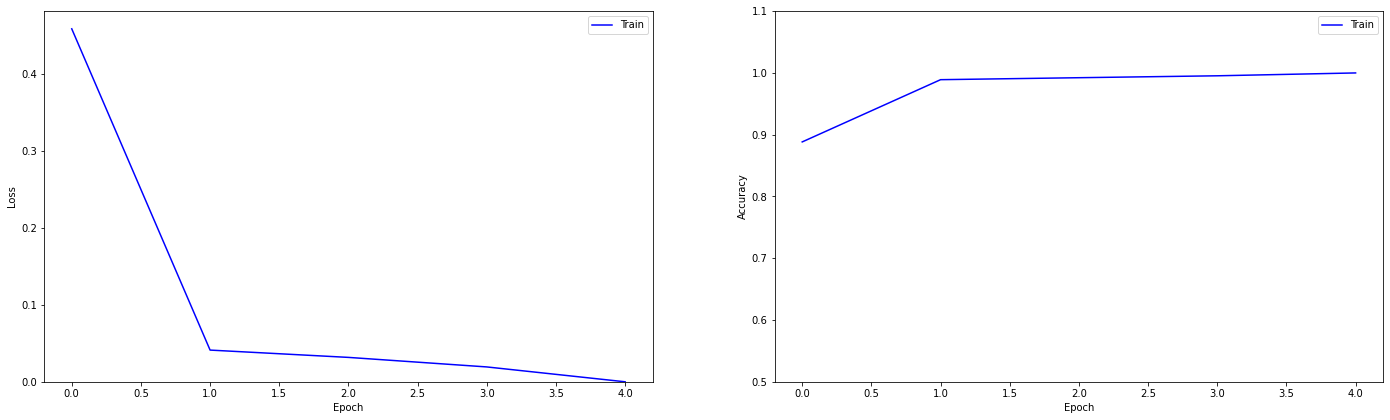

In [ ]:
plot_metrics(nn_model_history)

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Not applicable for this iteration of modeling

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
final_model = nn_model_0
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 131)               67203     
Total params: 14,781,891
Trainable params: 14,781,891
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('Loading and pre-processing the testing images...')
testing_datagen = ImageDataGenerator(**datagen_kwargs)
testing_generator = testing_datagen.flow_from_directory(directory=TEST_DIR,
                                                        target_size=TARGET_IMAGE_SIZE,
                                                        shuffle=False,
                                                        **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(testing_generator))

Loading and pre-processing the testing images...
Found 22688 images belonging to 131 classes.
Number of image batches per epoch of modeling: 709


In [ ]:
final_model.evaluate(testing_generator, verbose=1)

709/709 [==============================] - 19s 27ms/step - loss: 0.0762 - accuracy: 0.9847


[0.07623478025197983, 0.9846615195274353]

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:16:10.172029
